# Project 3 Stirred (not shaken)

By Mariane Udtian, Marius Skårdal & Fisayo Togun \

## Exercise 1: Write your own ODE solver
### Part 1

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from scipy import integrate 
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd

### Abstract
In this project, we will look deeper into the flow rate through an aorta arch using a CFD model. Three iterative methods were used to approximate solutions of simultaneous nonlinear equations. These methodes were Euler, Runge kutta 2 and Runge kutta 4. A simulator to compare the approximations for different values of N is also included. Further, it was shown that the numerical solution was in good agreement with the analytical solution for n=3. Moreover, the Steward-Hamilton equation was used with a given dataset to determine the injection rate q=5 L/min. Finally, we were able to fit our CSTR model into a CFD model. As the first model did not completely match the CFD model, scipy.optimize and a least square optimization was used to optimize the input parameters. Runge Kutta 4th method was used as it has the lowest value of error.   

### Theory
In this project, we will continue to investigate ordinary differential equations, but this time we are solving an initial value problem. Unlike boundary value problems where we use shooting methods, we will implement a "steppers method" for the initial value problem: 
$$\frac{dx}{dt}=f \rightarrow \Delta x \approx f \Delta t \\
x_{i+1} \approx x_i + f \Delta t$$
In the first exercise, we will use both the Eulers method and Runge-Kutta to solve the system. Accordingly, the general formula for Euler´s method is:
$$ y_{i+1} = y_i + hf(x_i, y_i) \\
x_{n+1} = x_n + h$$
where $y_{i+1}$ is the next estimated solution value, $y_i$ is the current value, h is the interval between steps. $f(x_i, y_i)$ is the value of the derivative at the current $(x_i, y_i)$ point. It is worth mentioning that Euler´s method is generally horrible as it´s only first-order convergent, but on the other hand, very simple. Euler´s method uses a forward derivative in time, leading to the error of O(h), where h is the step size. This is where poor and implies that the function is very sensitive to the choice of h. Runge-Kutta on the other hand is the general "go-to-method" when solving initial value ODEs. This method is very powerful as well as robust. The RK2 follows: 
$$
k_1 = \Delta t f(x_i, t_i) \\
k_2 = \Delta t f(x_i + \frac{1}{2}k_1, t_i + \frac{1}{2} \Delta t)
$$
For small $\Delta t$:
$$k_2 \approx \Delta t [f(x_i, t_i) + \frac{1}{2}k_1 \partial_x f(x_i, t_i)  + \frac{1}{2} \Delta t \partial_t f(x_i, t_i)] + O(\Delta t^3)$$
$$
\rightarrow x_{i+1} = x_i + \Delta t f(x_i, t_i) + \frac{\Delta t^2}{2} \partial_t f(x_i, t_i) + \frac{\Delta t^2}{2} f(x_i, t_i) \partial_x f(x_i, t_i)+O(\Delta t^3)
\rightarrow x_*(x_i + \Delta t) - x_{i+1} = O(\Delta t^3)
$$
Note that $O(\Delta t^2)$ accuracy is better than $O(\Delta t)$ in euler, but each iteration requires 2 evaluations of f(x, t). Moving on, the 4.th order RK follows:
$$
k_1 = \Delta t f(x_i, t_i) \\
k_2 = \Delta t f(x_i + \frac{1}{2}k_1, t_i + \frac{1}{2} \Delta t) \\
k_3 = \Delta t f(x_i + \frac{1}{2}k_2, t_i + \frac{1}{2} \Delta t) \\
k_4 = \Delta t f(x_i + k_3, t_i + \Delta t)
$$

$$
x_{i+1} = x_i + \frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} + \frac{k_4}{6} + O(\Delta t^5)
$$

$\rightarrow$ Error comes at order $(\Delta t)^5$
Note that we also implement an inbuilt scipy ODE solver, which solves a system of ODE using RK4. However, this method also uses Richardson-extrapolation on top to achieve higher accuracy. Richardson-extrapolation uses 2 lattice spacing to cancel errors. 

Write the equations of n-tanks in a form of 2 coupled 1st order equations 
$$
\frac{d}{dt}y = f(t,y)
$$

$$
y = 
\left(
\begin{array}{c}
C_0 \\
C_1 \\
. \\
. \\
. \\
C_{N-1}
\end{array}
\right), \quad \frac{d}{dt }\left(
\begin{array}{c}
C_0 \\
C_1 \\
. \\
. \\
. \\
C_{N-1}
\end{array}
\right) = \frac{N}{\tau} \left(
\begin{array}{c}
C_{inj}-C_0 \\
C_0-C_1 \\
. \\
. \\
. \\
C_{N-2} - C_{N-1}
\end{array}
\right) = f(y)
$$



Starting from initial condition $C_0(0) = 1$ and $C_i(0) = 0$, evolve the system few time steps using the Euler algorithm with dt = 0.01. $C_{inj}=0$

For the last part we use a least square optimization in order to optimize the input parameters. The sum of the squared residuals is defined as: 
$$
SSR = \sum_{i=0}^{N_d - 1} r^2_i = \sum_{i=0}^{N_d - 1} (d_i - m_i)^2
$$

In [2]:
class ODEsolver:
    def __init__(self,n,tfinal,dt=0.02,t0=0,V=1,q=250/3,c0=1,c_in=0,tau=2,y_start=0,t_start=0, injprot='none',data='Aneurysm_rect_1s.csv'):
        self.V=V
        self.q=q
        self.c0=c0
        self.c_in=c_in
        self.n=n
        self.t=t0
        self.tau=V/q
        self.tfinal=tfinal
        self.dt=dt
        self.injprot=injprot
        self.t0=t0
        self.t_span=np.linspace(0, 10,100)
        self.y_start=y_start
        self.t_start=t_start
        self.data=data
        self.dat=pd.read_csv(self.data)
        self.Minj=83.333    #[g]
        self.ydat = self.dat["Concentration"].values
        self.xdat = self.dat['Time'].values
        
    def yd(self):
        g=np.zeros(self.n)
        g[0]=self.c0
        return(g)
    
    def rhs(self,y,t):
        #####call c_in in here as a function of t
        if self.injprot=="rect_1s":
            gh=np.array(self.c_inj_rect_1s(t))
        elif self.injprot=="rect_2s":
            gh=np.array(self.c_inj_rect_2s(t))
        elif self.injprot=="rect_3s":
            gh=np.array(self.c_inj_rect_3s(t))
        elif self.injprot=="ramp_1s":
            gh=np.array(self.c_inj_ramp_1s(t))
        else:
            gh=np.array(self.c_in)
        gh=np.append(gh, y[:-1]) 
        fy=gh-y
        return(self.n/self.tau)*fy
    
    def step(self,rhs,y,t,method):
        if method == 'euler':
            return self.dt*rhs(y,t)
        elif method == 'rk2':
            return self.rk2_step(rhs,y,t)
        elif method == 'rk4':
            return self.rk4_step(rhs,y,t)
        else:
            print('unknown method')
        
    def rk2_step(self,rhs, y, t):
        k1=self.dt*rhs(y,t)
        k2=self.dt*rhs(y+0.5*k1,t+self.dt*0.5)
        return k2
    
    def rk4_step(self,rhs,y,t):
        k1=self.dt*rhs(y,t)
        k2=self.dt*rhs(y+0.5*k1,t+0.5*self.dt)
        k3=self.dt*rhs(y+0.5*k2,t+0.5*self.dt)
        k4=self.dt*rhs(y+k3,t+self.dt)
        return (k1+2*k2+2*k3+k4)/6
    
    def ode_solver(self,method):
        '''Write a function that solves the ODE using the Euler algorithm. The function 'Euler(y0, f, tlist)' 
        should be a function of the initial condition 'y0=[x0, v0]', the right-hand-side of the differential 
        equation 'f(t, y)' and a list 'tlist = [t0, tf, dt]' containing initial time 't0', final time 'tf' and 
        the time step 'dt'.'''
        sim_t=self.t0
        y_old=self.yd()
        self.y_start=[]
        self.t_start=[]
        while sim_t < self.tfinal:
            self.y_start.append(y_old)
            self.t_start.append(sim_t)
            y_next=y_old+self.step(self.rhs,y_old,sim_t,method)
            sim_t = sim_t + self.dt
            y_old=y_next
        return np.array(self.t_start),np.array(self.y_start)

    def analytic(self, t_):
        #t_=self.t_span
        an_1 = np.exp(-t_/self.tau)
        an_2 = (2*t_/self.tau)*np.exp(-2*t_/self.tau)
        an_3 = 9*t_*t_/self.tau/self.tau/2*np.exp(-3*t_/self.tau)
        return an_1, an_2, an_3
    
    def anl3(self, t_):
        return (9*t_*t_/self.tau/self.tau/2*np.exp(-3*t_/self.tau))
    
    def od_sol(self, rhs):
        y_ = [1, 0, 0]
        t_=np.linspace(0, 10,100)
        rhs=self.rhs
        res=odeint(rhs, y_, t_, rtol=1e-14) #rtol determine the error control performed by the solver
        return res
    
    def odeint_sol(self, rhs):
        y_ = [1, 0, 0]
        t_=self.t_span
        rhs=self.rhs
        res=self.od_sol(1)
        if self.n==1:
            plt.plot(t_, res[:,2], label='Odeint')
            plt.plot(t_, self.analytic(t_)[self.n-1], 'o', label='analytic')
        if self.n==2: 
            plt.plot(t_, res[:,2], label='Odeint')
            plt.plot(t_, self.analytic(t_)[self.n-1], 'o', label='analytic')
        else: 
            plt.plot(t_, res[:,2], label='Odeint')
            plt.plot(t_, self.analytic(t_)[self.n-1], 'o', label='analytic')
        plt.title(self.n)
        plt.xlabel('Time [seconds]')
        plt.ylabel('Concentration [g/ml]')
        plt.grid()
        plt.legend()
        plt.show()
    
        
    def plotz(self, method):  
        ''' plots the analytical (odeint) or the numerical odesolver '''

        if method == 'odeint':
            t_3=np.linspace(0, 10,100)
            gyt=self.od_sol(1)
            plt.plot(t_3, gyt[:,2])
            plt.title('Scipy Odeint')
            plt.grid()
        else:
            time=np.array(self.ode_solver(method)[0])
            conc=np.array(self.ode_solver(method)[1])
            plt.plot(time,conc[:,-1])
            plt.title(method)
            plt.xlabel('Time [seconds]')
            plt.ylabel('Concentration [g/ml]')
            plt.grid()
            

                   
    def Area_under_graph(self):
        '''This function callculates the area under the curve for exercise 2 part1'''
        dats = self.dat
        M_inj=self.Minj
        np_data = dats.to_numpy()
        x=np_data[:,:-1]
        y=np_data[:,1:]
        d=len(y)
        z=y[0]+y[-1]+2*np.sum(y[1:-1])
        h=((x[1]-x[0])/2)*z
        z=M_inj/h*(60/1000)
        return print(z)
    
    def c_inj_rect_1s(self,t,ti=np.array([0,1.,1.,2.,2.]),ci=np.array([1,1,0,0,0])):
        return np.interp(t,ti,ci)
    def c_inj_rect_2s(self,t,ti=np.array([0,1.,2.,2.,3.,4.,4.]),ci=np.array([1,1,1,0,0,0,0])):
        return np.interp(t,ti,ci)
    def c_inj_rect_3s(self,t,ti=np.array([0,1.,2.,3.,3.,4.]),ci=np.array([1,1,1,1,0,0,])):
        return np.interp(t,ti,ci)
    def c_inj_ramp_1s(self,t,ti=np.array([0,1.,1.,2.,3.,4.]),ci=np.array([0,1,0,0,0,0,])):
        return np.interp(t,ti,ci)
    
    def plot_rect(self):
        '''makes a plot for all injection protocols'''
        t=np.linspace(0,5, 1000)
        ti=np.array([[0,1.,1.,2.,2., 3., 4.],
                     [0,1.,2.,2.,3.,4.,4.],
                     [0,1.,2.,3.,3.,4., 4.], 
                     [0,1.,1.,2.,3.,4., 4.], 
                     [0., 2., 2.,3., 4., 4., 4],
                     [0., 1., 1., 2, 2, 3, 3]])
        ci=np.array([[1,1,0,0,0, 0, 0],
                     [1,1,1,0,0,0,0],
                     [1,1,1,1,0,0, 0], 
                     [0,1,0,0,0,0,0], 
                     [0, 1., 0.,0., 0., 0.,0], 
                     [0.7, 0.7, 0, 0, 1, 1, 0]])
        tit=['recs', 'rect_2s', 'rect_3s', 'ramp_1s', 'ramp_2s', 'biphasic']
        for i in range(len(ti)):
            plt.plot(t, self.c_inj_rect_2s(t, ti[i], ci[i]))
            plt.title(tit[i])
            plt.xlabel('Time [s]')
            plt.ylabel('Concentration [g/ml]')
            plt.grid()
            plt.show()
            
    def dataInp(self,read):
        data=pd.read_csv(read) #reads the data 
        np_data = data.to_numpy()
        x=np_data[:,:-1]
        y=np_data[:,1:]
        M=self.ode_solver(method='rk4')
        time=M[0]
        conc=(M[-1]).transpose()[-1]
        plt.scatter(x, y, color='red', linewidths=.5)
        plt.plot(time, conc)
        plt.xlabel('Time [s]')
        plt.ylabel('Concentration [g/ml]')
        plt.grid()

   

    def fit_func(self,n,V):
        model=ODEsolver(n, V=V,tfinal=5,injprot='rect_1s')
        t_array,y_array=model.ode_solver(method='rk4')
        conc=y_array[:,-1]
        return t_array,conc

    def diff_sqr_sum(self,n,V):
        #Sum of squared residuales
        diff=(self.ydat-self.fit_func(n,V)[-1])**2
        return np.sum(diff)
    
    def optimize(self):
        '''This optimizer uses a range of n and v values to get the lowest SSR and returns those n and v values'''
        V_vect=np.linspace(50,400,50)
        n_vect=np.arange(10,61)
        main_err=np.array([])
        for n in n_vect:
            error=np.array([])
            for i in V_vect:
                fg=self.diff_sqr_sum(n,i)
                error=np.append(error,fg)
            main_err=np.append(main_err,error)
        w=main_err.reshape(len(n_vect),len(V_vect))
        min_=w.min()
        position=np.where(w<=min_)
        optimal_n=n_vect[position[0]]
        optimal_V=V_vect[position[1]]
        print("optimal n is",optimal_n)
        print("optimal V is",optimal_V)

    def fit_func2(self,t,V):
        model=ODEsolver(n=32, V=V, tfinal=5, injprot='rect_1s')
        t_array,y_array=model.ode_solver(method='rk4')
        conc=y_array[:,-1]
        return np.interp(t,t_array,conc)
        
    def scipy_optimizer(self):
        ''' This function is used to better optimize the V'''
        x = self.xdat
        y = self.ydat
        popt, pcov = curve_fit(self.fit_func2, x, y, 100)
        print('The optimal parameters are:' , *popt)



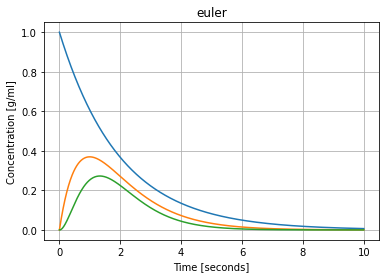

In [4]:
#Test algorithm for n-tanks
n=[1, 2, 3]

for i in n:
    tets=ODEsolver(i,tfinal=10,dt=0.01,V=2,q=1)
    tets.plotz('euler')

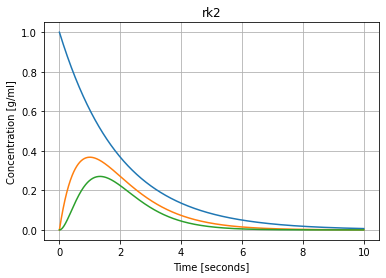

In [5]:
for i in n:
    tets=ODEsolver(i,tfinal=10,dt=0.01,V=2,q=1)
    tets.plotz('rk2')

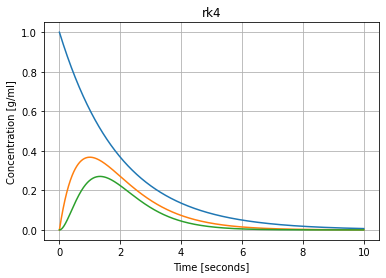

In [6]:
for i in n:
    tets=ODEsolver(i,tfinal=10,dt=0.01,V=2,q=1)
    tets.plotz('rk4')

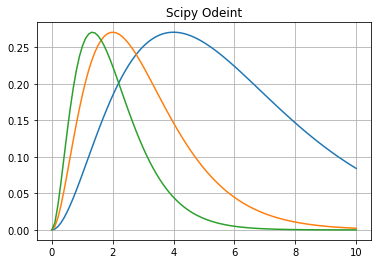

In [7]:
for i in n:
    tets=ODEsolver(i,tfinal=10,dt=0.01,V=2,q=1)
    tets.plotz('odeint')

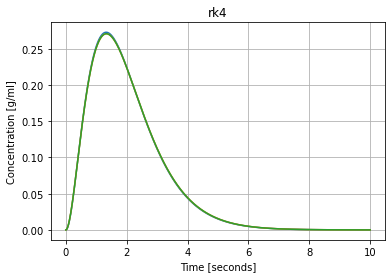

In [8]:
u=3
j=['euler', 'rk2', 'rk4']
for i in j:
    tets=ODEsolver(n=3,tfinal=10,dt=0.01,V=2,q=1)
    tets.plotz(i)

In this case, the solution to all algorithms seems to be in good agreement. Concentration seems to decrease more rapidly with time, for n=0. The simulator was tested with the inbuilt scipy.odeint. As the result is in good agreement with the scipy.odeint method, this one was used to compare with the analytical solution, found in the next part. Note that the result for n=0 is very different in odeint solution.  

### Part 2
Test the implementation against analytical solution:
$$
C_0(t) = exp(- \frac{t}{\tau}) \\
C_1(t) = \frac{2t}{\tau}exp(- \frac{2t}{\tau}) \\
C_2(t) = \frac{9t^2}{2 \tau^2}exp(- \frac{3t}{\tau}) 
$$

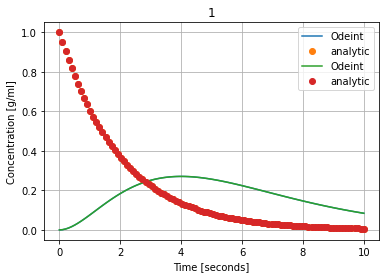

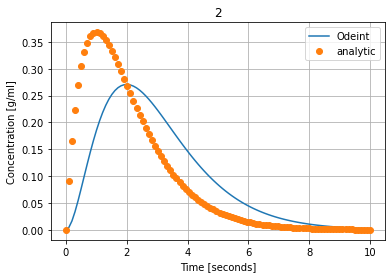

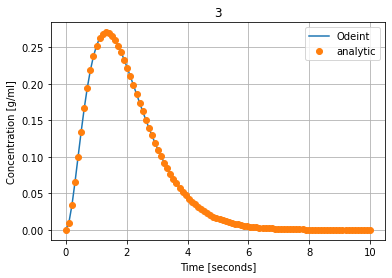

In [9]:
n=[1, 2, 3]
for i in n:
    tets=ODEsolver(i,tfinal=10,dt=0.01,V=2,q=1) 
    tets.odeint_sol(i)   #Test the analytical with odeint solver

As we can observe, the analytical solution and numerical solution do not match well for n=0. The best result is obtained for n=3.

### Part 3
Pick n=1, 2 or 3, and plot the numerical error at t=1 for the last tank and dt values in the range 0.1, ..., 0.001. For this part, we chose to look at the error for n=3 and for the last tank. 

[0.024875226435067233, 0.004559292467954723, 0.0018625636267368129, 0.0009365690616478517, 0.0004695065715497604, 0.00018808368258915742, 9.408768543028856e-05, 4.3938872210658175e-05, 0.00010988516245097335, 2.1966905294712458e-05, 1.0982820067173549e-05]


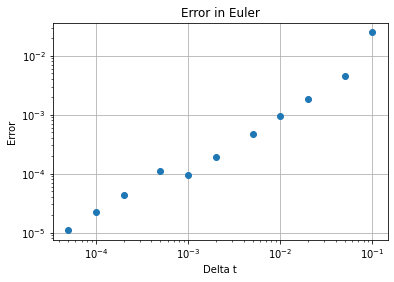

In [10]:
dt=[0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0002, 0.0005,0.0001, 0.00005] #, 0.0001]
err_rk4=[]
err_rk2=[]
err_euler=[]
for i in dt:
    tets=ODEsolver(n=3,tfinal=1, dt=i,V=2,q=1)
    rk4=tets.ode_solver('rk4')[1][-1][-1]
    rk2=tets.ode_solver('rk2')[1][-1][-1]
    euler=tets.ode_solver('euler')[1][-1][-1]
    uk=tets.analytic(1)[-1] 
    #print(abs(rk4-uk), abs(rk2-uk), abs(euler-uk))
    err_rk4.append(abs(rk4-uk))
    err_rk2.append(abs(rk2-uk))
    err_euler.append(abs(euler-uk))

print(err_euler)
plt.plot(dt, err_euler,'o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Error")
plt.xlabel("Delta t")
plt.title('Error in Euler')
plt.grid()

[0.0002457381537863679, 0.006885831311048668, 0.0026136833634448076, 0.0012813921188413735, 0.0006341740443263078, 0.00025208528166054123, 0.00012577705318150834, 1.881388655977645e-09, 1.174673863735265e-08, 4.705061340537497e-10, 1.1764622609433673e-10]


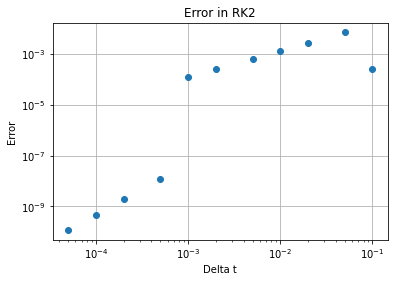

In [11]:
print(err_rk2)
plt.plot(dt,err_rk2, 'o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Error")
plt.xlabel("Delta t")
plt.title('Error in RK2')
plt.grid()

[6.5170223113586445e-06, 0.006829785139040784, 0.0025984307633412362, 0.0012771175231044707, 0.0006330504865625919, 0.00025190038002992354, 0.00012573040579738626, 1.6653345369377348e-16, 3.3861802251067274e-15, 5.551115123125783e-16, 2.0539125955565396e-15]


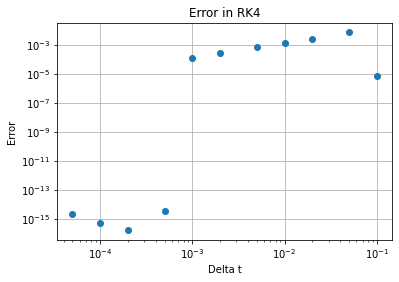

In [12]:
print(err_rk4)
plt.plot(dt, err_rk4,'o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Error")
plt.xlabel("Delta t")
plt.title('Error in RK4')
plt.grid()

By varying the values of dt, one can see how the error is larger in Euler, decreases some in RK2, and the smallest in RK4. Note that the Odeint has an inbuilt error function. The error here depends on the tolerated error. In Euler, the error scales as a factor of 10, as expected. In rk4 and rk2 we obtain very small errors when dt becomes small(<0.001).  0.1 seems to be too big for rk2 and rk4. As mentioned earlier, RK4 is the most robust algorithm and gives the smallest numerical error. 

## Exercise 2: Fit CSTR model to CFD model: Healthy aorta
### Part 1
According to Steward-Hamilton equation, the injection rate q is determined by:
$$
q = \frac{M_{inj}}{\int_0^{\infty}C_{out}(t)dt}
$$
In the case of rect_1s, mass of a tracer we inject in $M_{inj} = 83.333$

In [13]:
testings=ODEsolver(n=3,tfinal=10,dt=0.01,V=2,q=1,injprot='none',data='Healthy_rect_1s.csv')
#Print injection rate q, unit L/min
testings.Area_under_graph()

[5.00598366]


### Part 2
Python functions that reproduces at least three other injection protocol than rect_1s 

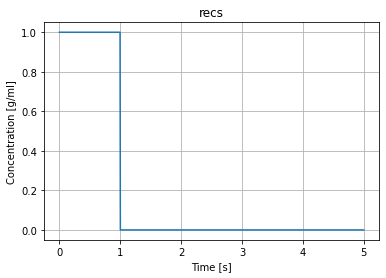

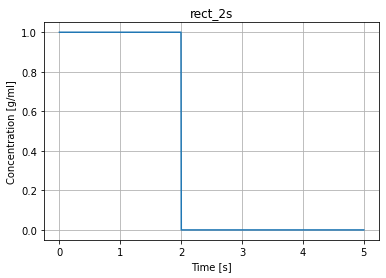

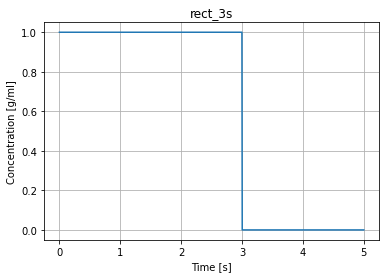

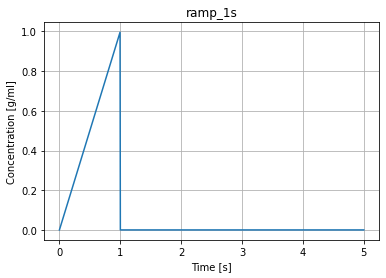

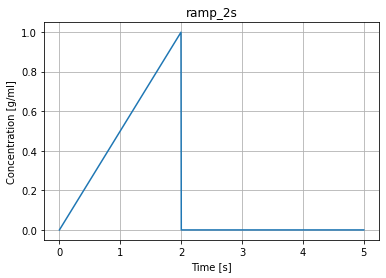

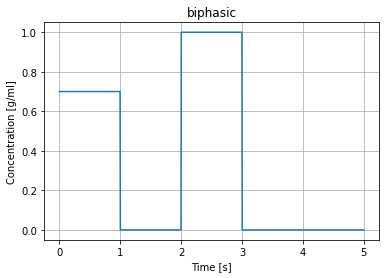

In [14]:
testings=ODEsolver(n=3,tfinal=10,dt=0.01)
testings.plot_rect()

### Exercise 2 part 3 

In [15]:
tess=ODEsolver(n=40,V=29, tfinal=5,injprot="rect_1s",data='Healthy_rect_1s.csv')
tess.optimize()

optimal n is [49]
optimal V is [200.]


In [16]:
testing=ODEsolver(n=49,V=20,dt=.02,tfinal=5,data='Healthy_rect_1s.csv')
testing.scipy_optimizer()
# we use the scipy optimize to compare to the other optimizer

The optimal parameters are: 200.90549807759623


### Exercise 2 part 4

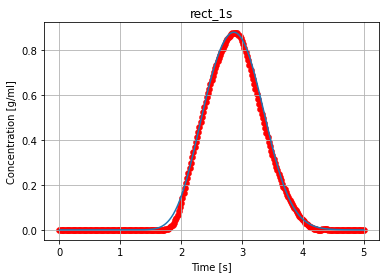

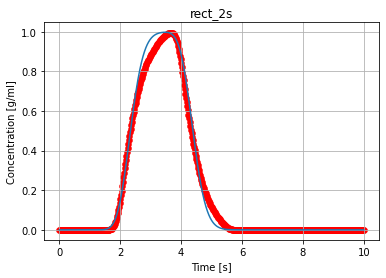

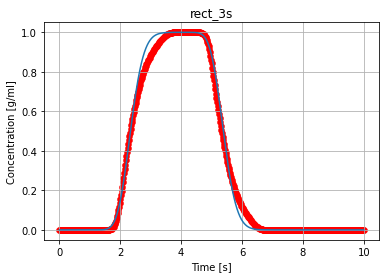

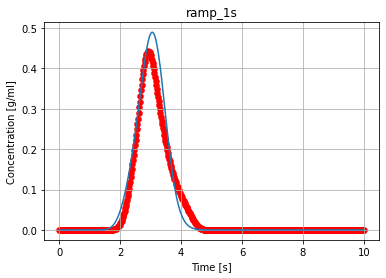

In [17]:
CSTR=['rect_1s','rect_2s','rect_3s','ramp_1s']
CFT=['Healthy_rect_1s.csv','Healthy_rect_2s.csv', 'Healthy_rect_3s.csv','Healthy_ramp_1s.csv']
t_curr=[5,10,10,10]
i=0
for i in range(0,4):
    tst=ODEsolver(n=49, V=200, tfinal=t_curr[i],dt=0.005, injprot=CSTR[i])
    tst.dataInp(CFT[i])
    plt.title(CSTR[i])
    plt.show()
    

## Exercise 3: Fit CSTR model to CFD model: Aorta with aneurysm

## Part 1 for Aneurysm

In [18]:
tess=ODEsolver(n=40,V=29, tfinal=5,injprot="rect_1s",data='Aneurysm_rect_1s.csv')
tess.optimize()

optimal n is [24]
optimal V is [207.14285714]


In [19]:
testing=ODEsolver(n=24,V=20,dt=.02,tfinal=5,data='Aneurysm_rect_1s.csv')
testing.scipy_optimizer()

The optimal parameters are: 206.65195314893683


## part 2

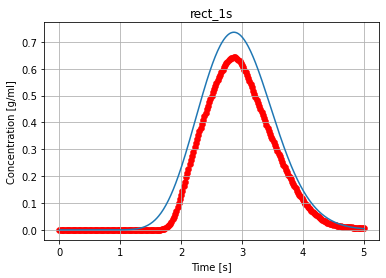

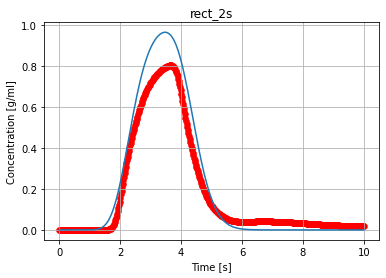

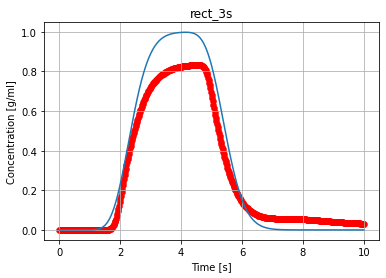

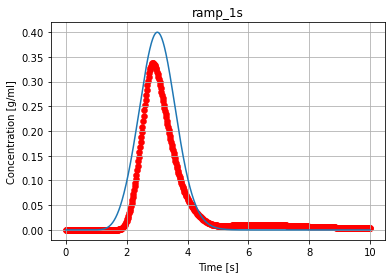

In [20]:
CSTR_ana=['rect_1s','rect_2s','rect_3s','ramp_1s']
CFT_ana=['Aneurysm_rect_1s.csv','Aneurysm_rect_2s.csv', 'Aneurysm_rect_3s.csv','Aneurysm_ramp_1s.csv']
t_curr=[5,10,10,10]
i=0
for i in range(0,4):
    tst=ODEsolver(n=24,V=206.65, tfinal=t_curr[i],dt=0.01, injprot=CSTR_ana[i])
    tst.dataInp(CFT_ana[i])
    plt.title(CSTR_ana[i])
    plt.show()

## Part 3 

The optimal number of components for a healthy patient was 49, whereas, for the aneurysm case, the optimal number of components was 24, which is half the value for a healthy patient. The pros of our simulator are that it works well for a healthy patient. When changing the volume of blood flow, our simulator meets some challenges. One of the main disadvantages is that the simulator is sensitive to changing the number of tanks and volume. However, the simulator works great even for larger time step dt, but becomes slow as dt becomes very small.     

## Part 4

The CSTR approach is good for simulating a plug flow system by combining several CSTRs in series which is what we do in the case of a healthy patient. From theory to simulate a plug flow system can be simulated by combining several CSTR in series.
In the case of the aneurysm, the system seems to behave more like a plug flow reactor combined with a semi-batch reactor, and using a set of CSTR in series will not capture this effect. 
It requires a high number of reactors with small volumes if this was to be simulated in a physical lab because we got a value of n= 49 Vtotal= 200ml
Natural science phenomenons can be simulated using to achieve relatively realistic processes. The simulation uses a 1-dimensional system and assumes that the vertical direction that is perpendicular to the direction of flow is even mixed. The assumption flows through with reality because blood is of even composition.
The blood flows through the system is equivalent through several small CSTR in series. In the case of the aneurysm to simulate the aneurysm chamber you will need some form of delayed flow at that point.


## Conclusion

Conclusion: In the previous task, we used Runge-Kutta 4th method to match data for a healthy patient and a sick patient with an aneurysm. Accordingly, our simulator matches well with the healthy patient. In the aneurysm case, we had to half the number of n to obtain the best match. However, our model does not fully match the CFD for an aneurysm. One can see how for a short pulse, the difference is not too big but becomes significant for a longer pulse. An aneurysm is a bulge in the wall of your blood vessel. This implies that the blood flow has a larger area to flow into. For a small pulse, the blood flow does not run inside much of the aneurysm. For longer pulses, on the other hand, the blood will also cover the areas of the aneurysm. This difference can be somehow fixed by applying diffusion to the blood flow, which is left as an optional exercise. 

Reflection by Marianne: I liked the length of this project much better. However, I am really satisfied with the fact that the previous project were the "hardest one", but with a steep learning curve. Also, with my theoretical background, i think it was a bit fun to apply theory into practical problems like this, as well as visualizing blood flow. 

Reflection by Olufisayo: This project was evenly balanced. I got to learn that real life processes can be simulated using python( flow systems), I was able to learn how to use scipy optimize to fit plots, and the interp function in numpy for creating plots. We also bult an optimizing function using the concept of SSR and this is something that is forever with me.

Reflection by Marius: The project was exciting from the start, to be able to apply knowledge from previous courses in differential equations in practical circumstances is greatly appreciated. I spent most of my time trying to figure out how to optimize the volume where the knowledge gained could prove to be useful later in my studies. I was also very happy with the workload on this project compared to the previous project as it was managable to get through at a reasonable time. 

### References
“Euler’s Method Explained with Examples.” FreeCodeCamp.org, 26 Jan. 2020, https://www.freecodecamp.org/news/eulers-method-explained-with-examples/.

$\newline$

“Runge.” Wikipedia, 21 Aug. 2019, https://www.en.wikipedia.org/wiki/Runge.
  $\newline $\
Singiresu S. Rao, Applied Numerical Methodes For Engineers And Scientists, University of Miami, Florida, 2002 $\newline $ \
Octave Levenspiel. Chemical Reaction Engineering / [Hauptbd.]. New York ; Weinheim, Wiley, 1999.
 \ $\newline$ \
Sowade, Olaf, et al. “Avoidance of Allogeneic Blood Transfusions by Treatment with Epoetin Beta (Recombinant Human Erythropoietin) in Patients Undergoing Open-Heart Surgery.” Blood, vol. 89, no. 2, 15 Jan. 1997, pp. 411–418, https://www.sciencedirect.com/science/article/pii/S0006497120767406, 10.1182/blood.V89.2.411. Accessed 9 Nov. 2022.

‌

